# Tutorial: Estimation of global effective connectivity based on MOU generative process
Authors: **Matthieu Gilson** and **Gorka Zamora-López**

<img src="Images/Logo_CAS_ICS.png" style="float:left; width:254px; heigth:50px " alt="INT logo" />
<img src="Images/Logo_CAS_ICS.png" style="float:right; width:254px; heigth:50px " alt="ICS-CAS logo" />

<br/>
<br/>
<br/>



---------------------

This notebook illustrates how to estimate the all-to-all pair-wise effective connectivity matrix from the observed (fMRI) activity. Methods of Effective Connectivity estimation employ various generative dynamical models as the underlying assumption on how activity propagates over a (brain) network. In this case, we will assume the multivariate Ornsteing-Uhlenbeck (MOU) process, which is a linear model of activity propagation in line with Gaussianity and linearity properties observed in fMRI data. For that, we will employ the [pyMOU](https://github.com/mb-BCA/pyMOU) Python package. For citation and reference see:

* M. Gilson, R. Moreno-Bote, A. Ponce-Alvarez, et al. (2016) "*[Estimation of Directed Effective Connectivity from fMRI Functional Connectivity Hints at Asymmetries of Cortical Connectome](https://doi.org/10.1371/journal.pcbi.1004762)*" PLoS Comput. Biol. **12(3)**:e1004762.
* M. Gilson, G. Zamora-López, V. Pallarés, et al. (2020) "*[Model-based whole-brain effective connectivity to study distributed cognition in health and disease](https://doi.org/10.1162/netn_a_00117)*" Network Neurosci. **4(2)**, 338–373.

In this tutorial notebook we will:
1. create an synthetic random network (estructural connectivity, SC),
2. run a simulation of the network's activity (the multivariate signals),
3. estimate the effective connectivity (EC) from the simulated signals, and
4. compare the resulting EC estimation to the original structural matrix.


--------------------

### Dependencies

The Notebook requires a Python (>=3.6) installation together with *NumPy* (>1.6) and *Scipy*. For running the simulations and the EC estimation we will use the *pyMOU* package, and *Matplotlib* will be employed for the visualization of the results.

Please make sure these packages are installed in the same environment in which this notebook is running.


### Import the libraries

To get started, the first thing we need is to load the libraries we will need to work. Start importing the built-in and third party 
libraries.

In [1]:
# Python standard library imports
# Third-party imports
import numpy as np
import numpy.random
import scipy.linalg as spl
import scipy.stats as stt
import matplotlib.pyplot as plt
#%matplotlib inline
# Our libraries
import pymou as pm


### Create a structural connectivity matrix
We first generate a random weighted graph, with positive weights drawn from a uniform distribution.

w_min: 0.08333333333333334
w_max: 0.21666666666666667


Text(0.5, 1.0, 'original connectivity')

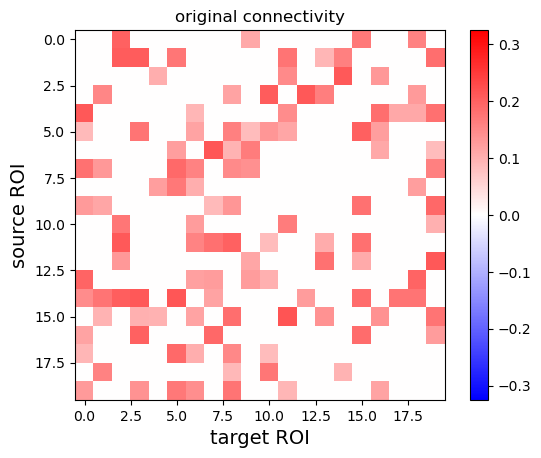

In [2]:
N = 20 # number of nodes

# Define some masks for later use (on connectivity and covariance matrices)
mask_diag = np.eye(N, dtype=bool)
mask_offdiag = np.logical_not(mask_diag)

d = 0.3 # density of connectivity
w_min=0.5/N/d
w_max=1.3/N/d
print( "w_min:", w_min )
print( "w_max:", w_max )

# # generate random matrix for original connectivity
#C_orig = pmt.make_rnd_connectivity(N, density=d, w_min=0.5/N/d, w_max=1.3/N/d)

# Generate the random weighted structural connectivity matrix
C_orig = w_min + (w_max - w_min) * np.random.rand(N,N)
C_orig[np.random.rand(N,N) > d] = 0
# Remove diagonal entries (self-loops)
C_orig[np.eye(N, dtype=bool)] = 0

# Visualise the connectivity matrix
vmax = np.abs(C_orig).max() * 1.5

plt.figure()
plt.imshow(C_orig, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('original connectivity')



### Simulation

We now run a simulation of the dynamical activity on the network, and visualise the resulting signals for the `N` nodes.

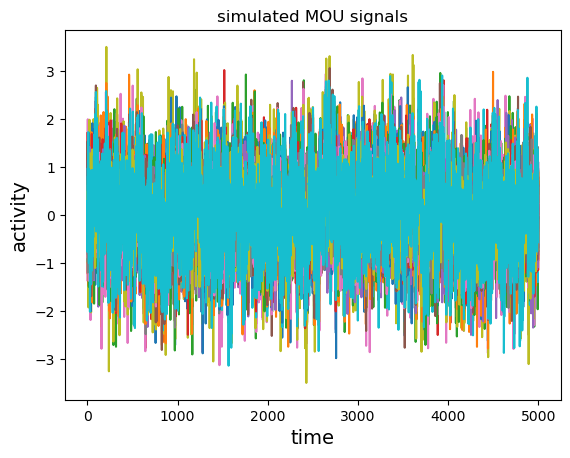

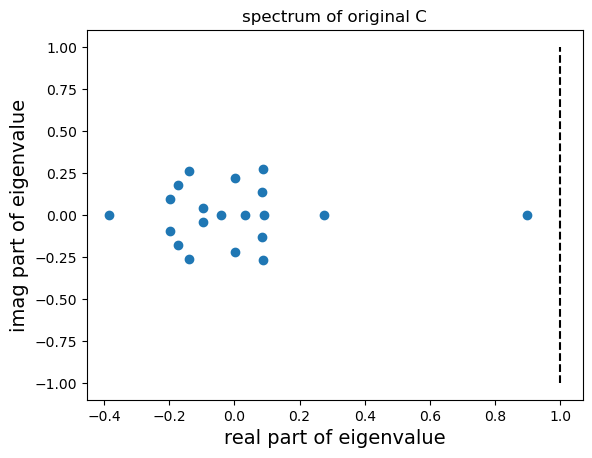

In [3]:
# generate diagonal matrix with inhomogeneous values for input covariances
Sigma_orig = np.eye(N) * ( np.random.rand(N) * 0.5 + 0.5 )

# create MOU process with C_orig and Sigma_orig
mou_orig = pm.MOU(C=C_orig, Sigma=Sigma_orig)

# simulate
T = 5000 # time in seconds
ts_sim = mou_orig.simulate(T)

# plot of activity
plt.figure()
plt.plot(range(T),ts_sim)
plt.xlabel('time')
plt.ylabel('activity')
plt.title('simulated MOU signals')


# spectrum of original connectivity
D = np.linalg.eigvals(C_orig)
plt.figure()
plt.scatter(np.real(D),np.imag(D))
plt.plot([1,1],[-1,1],'--k')
plt.xlabel('real part of eigenvalue')
plt.ylabel('imag part of eigenvalue')
plt.title('spectrum of original C')

plt.show()

We compare the match between the simulated and theoretical covariances (the larger the simulation duration $T$, the better the fit).

Q0 fit with theory: PearsonRResult(statistic=np.float64(0.9966934348875441), pvalue=np.float64(0.0))
Q1 fit with theory: PearsonRResult(statistic=np.float64(0.9945416839226213), pvalue=np.float64(0.0))



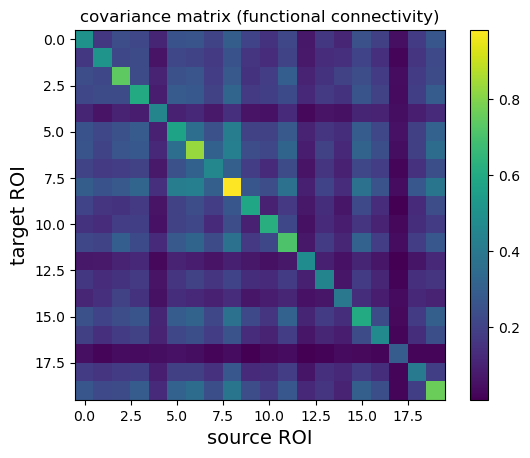

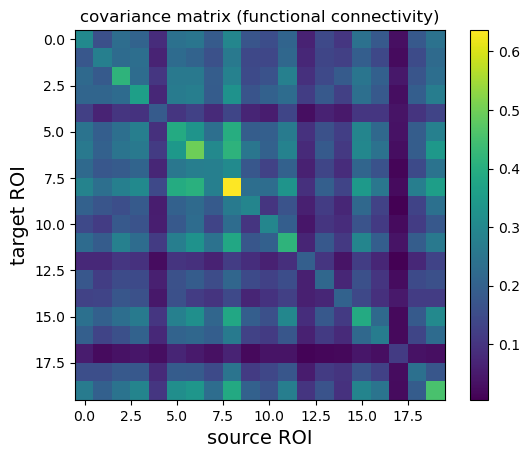

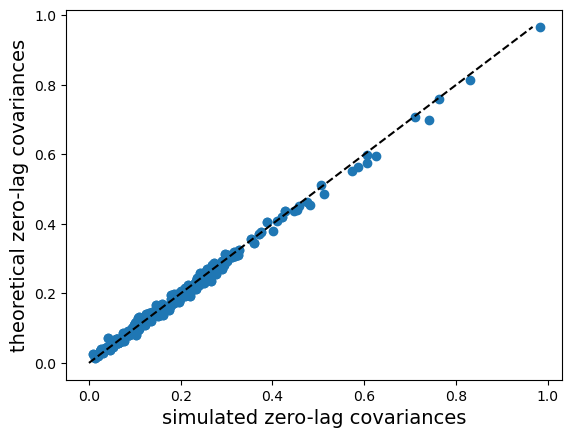

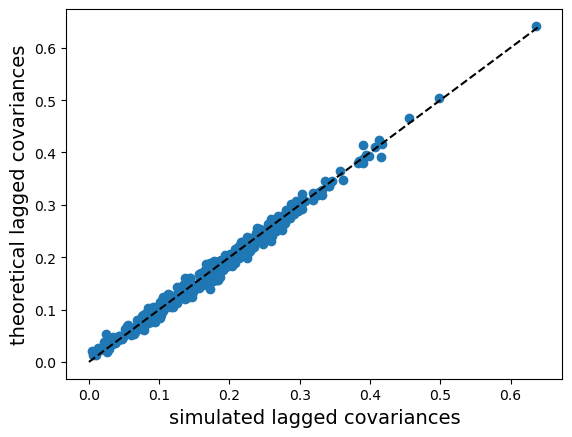

In [4]:
Q0_sim = np.tensordot(ts_sim[0:T-1,:],ts_sim[0:T-1,:],axes=(0,0)) / (T-2)
Q1_sim = np.tensordot(ts_sim[0:T-1,:],ts_sim[1:T,:],axes=(0,0)) / (T-2)

J_orig = -np.eye(N) + C_orig
Q0_th = spl.solve_continuous_lyapunov(J_orig.T, -Sigma_orig)
Q1_th  = np.dot(Q0_th , spl.expm(J_orig))

# fit as measured by the Pearson correlation between the vectorized matrices
print('Q0 fit with theory:', stt.pearsonr(Q0_sim.flatten(), Q0_th.flatten()))
print('Q1 fit with theory:', stt.pearsonr(Q1_sim.flatten(), Q1_th.flatten()))
print()

# Plot the results
plt.figure()
plt.imshow(Q0_sim)
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('covariance matrix (functional connectivity)')

plt.figure()
plt.imshow(Q1_sim)
plt.colorbar()
plt.xlabel('source ROI')
plt.ylabel('target ROI')
plt.title('covariance matrix (functional connectivity)')

plt.figure()
plt.plot([0,Q0_th.max()],[0,Q0_th.max()],'--k')
plt.scatter(Q0_sim, Q0_th)
plt.xlabel('simulated zero-lag covariances')
plt.ylabel('theoretical zero-lag covariances')

plt.figure()
plt.plot([0,Q1_th.max()],[0,Q1_th.max()],'--k')
plt.scatter(Q1_sim, Q1_th)
plt.xlabel('simulated lagged covariances')
plt.ylabel('theoretical lagged covariances')

plt.show()

### Connectivity estimation
Finally, we use the **pyMOU** package to infer the pair-wise effective connectivity from the simulated signals. We illustrate the estimation using two different optimization methods: "*Lyapunov optimization*" and the "*Moments method*."


#### Case-1: Lyapunov optimization

This Lyapunov optimization method is a gradient descent, which iteratively tunes the MOU parameters (C and Sigma) to reproduce the empirical covariances (zero-lag and lagged).

In [5]:
# Lyapunov optimization vanilla style
mou_LO = pm.MOU()
mou_LO.fit(ts_sim, lag=1)

C_LO = np.copy(mou_LO.J)
C_LO[mask_diag] = 0.0

This version of the Lyapunov optimization involves topological constraints on the connectivity estimate (in short, we know which connections exist and they are the same as in the original connectivity). As before, it tunes the time constant tau.

In [6]:
# Lyapunov optimization with topological constraints
mou_LO_topo = pm.MOU()
mou_LO_topo.fit(ts_sim, lag=1, mask_C=C_orig>0, eta_tau=0.05)

C_LO_topo = np.copy(mou_LO_topo.J)
C_LO_topo[mask_diag] = 0.0

This version of the Lyapunov optimization constrains the estimated weights ot be positive (like in the original connectivity). In addition, it tunes the time constant tau that is equivalent to a self-connection for each node (individually for each node).

In [7]:
# Lyapunov optimization with positive constraint on the estimated weights and adapting tau
mou_LO_pos = pm.MOU()
mou_LO_pos.fit(ts_sim, lag=1, min_C=0.0, eta_tau=0.05)

C_LO_pos = np.copy(mou_LO_pos.J)
C_LO_pos[mask_diag] = 0.0

#### Case-2: Moments method

The moment estimation method is a direct calculation involving the matrix logarithm.

In [8]:
# moments method
mou_mom = pm.MOU()
mou_mom.fit(ts_sim, lag=1, method='moments')

C_mom = np.copy(mou_mom.J)
C_mom[mask_diag] = 0.0

### Comparison of estimation methods

We visually compare the estimated connectivity matrices.

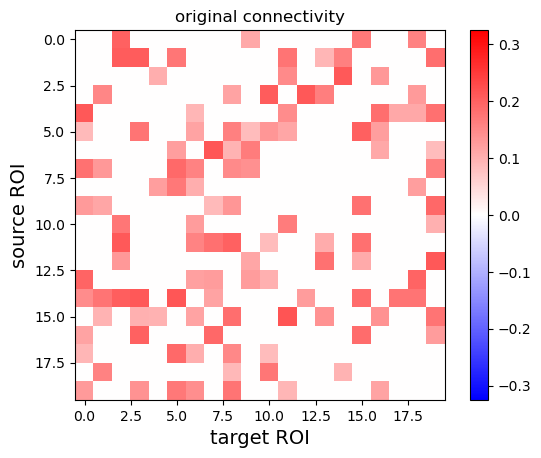

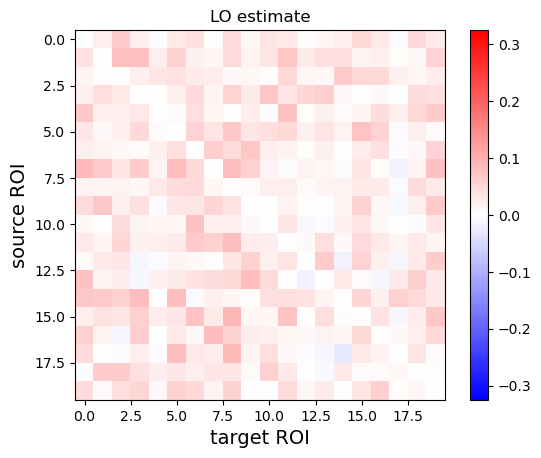

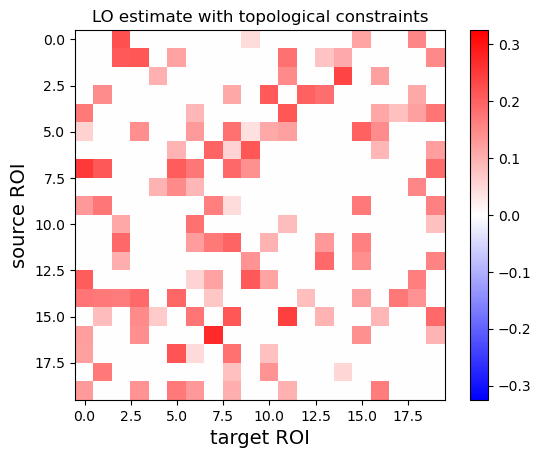

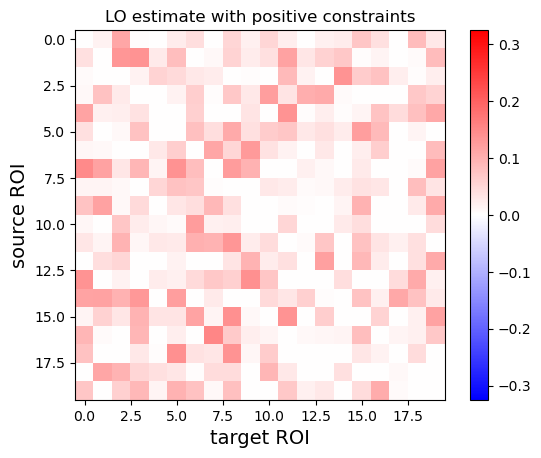

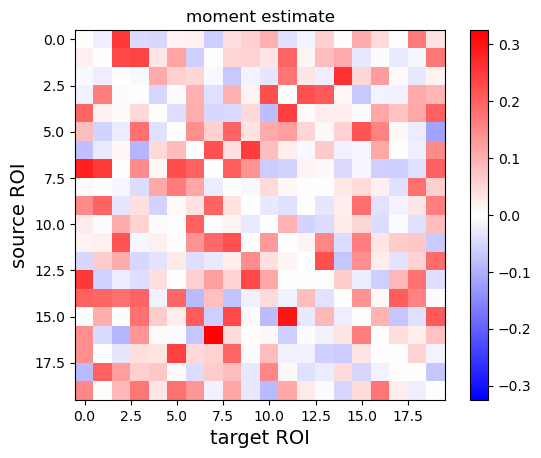

In [9]:
# TODO: Organise the visualization into a grid, for better comparison
# matrix plots
vmax = np.abs(C_orig).max() * 1.5

plt.figure()
plt.imshow(C_orig, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('original connectivity')

plt.figure()
plt.imshow(C_LO, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('LO estimate')

plt.figure()
plt.imshow(C_LO_topo, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('LO estimate with topological constraints')

plt.figure()
plt.imshow(C_LO_pos, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('LO estimate with positive constraints')

plt.figure()
plt.imshow(C_mom, vmin=-vmax, vmax=vmax, cmap='bwr')
plt.colorbar()
plt.xlabel('target ROI')
plt.ylabel('source ROI')
plt.title('moment estimate')

plt.show()

We plot the estimates against the original (the dashed line indicates a perfect match).

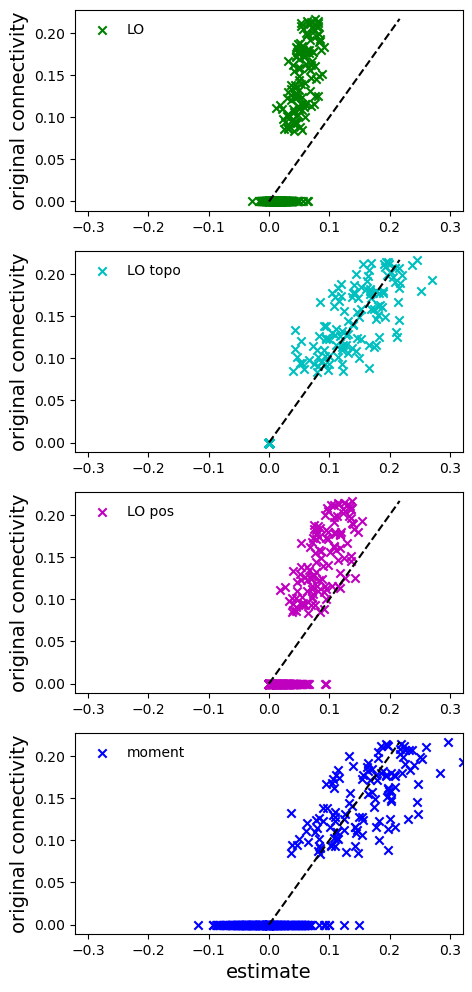

In [10]:
# match between original connectivity and each estimate
vmax = max(( np.abs(C_LO).max(), np.abs(C_mom).max() ))

plt.figure(figsize=[5,12])
plt.subplot(411)
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.scatter(C_LO, C_orig, color='g', marker='x', label='LO')
plt.axis(xmin=-vmax, xmax=vmax)
plt.legend()
plt.ylabel('original connectivity')
plt.subplot(412)
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.scatter(C_LO_topo, C_orig, color='c', marker='x', label='LO topo')
plt.axis(xmin=-vmax, xmax=vmax)
plt.legend()
plt.ylabel('original connectivity')
plt.subplot(413)
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.scatter(C_LO_pos, C_orig, color='m', marker='x', label='LO pos')
plt.axis(xmin=-vmax, xmax=vmax)
plt.legend()
plt.ylabel('original connectivity')
plt.subplot(414)
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.scatter(C_mom, C_orig, color='b', marker='x', label='moment')
plt.axis(xmin=-vmax, xmax=vmax)
plt.legend()
plt.xlabel('estimate')
plt.ylabel('original connectivity')
plt.legend()

plt.show()

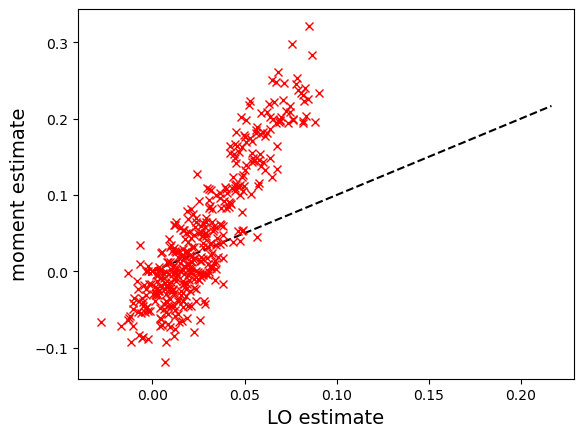

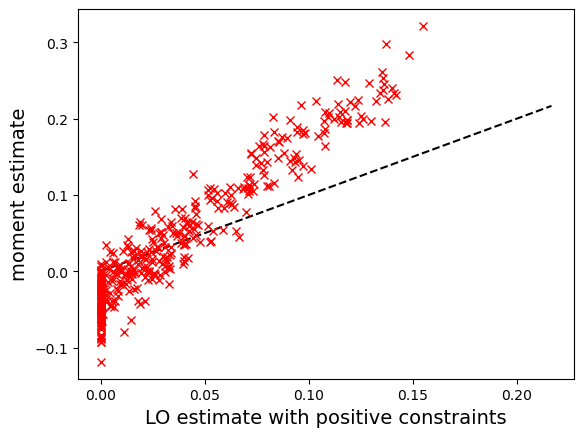

In [11]:
# match between estimates

plt.figure()
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.plot(C_LO,C_mom,'xr')
plt.xlabel('LO estimate')
plt.ylabel('moment estimate')

plt.figure()
plt.plot([0,C_orig.max()],[0,C_orig.max()],'--k')
plt.plot(C_LO_pos,C_mom,'xr')
plt.xlabel('LO estimate with positive constraints')
plt.ylabel('moment estimate')

plt.show()

To compare the estimates in a more quantitative manner, we calculate statistics for the goodness of fit as measured by the Pearson correlation coefficient between the vectorized matrices:
- model versus empirical covariances
- model versus original connectivity

In [12]:
print('- model fit of empirical covariances')
print('LO:',mou_LO.d_fit['correlation'])
print('LO topo:',mou_LO_topo.d_fit['correlation'])
print('LO pos:',mou_LO_pos.d_fit['correlation'])
print('moments:',mou_mom.d_fit['correlation'])
print()
print('- fit with original C')
print('LO:',stt.pearsonr(C_orig.flatten(),C_LO.flatten()))
print('LO topo:',stt.pearsonr(C_orig.flatten(),C_LO_topo.flatten()))
print('LO pos:',stt.pearsonr(C_orig.flatten(),C_LO_pos.flatten()))
print('moments:',stt.pearsonr(C_orig.flatten(),C_mom.flatten()))
print('moments + positive weights:',stt.pearsonr(C_orig.flatten(),np.maximum(C_mom,0).flatten()))

- model fit of empirical covariances
LO: 0.9761440939447065
LO topo: 0.987551400117004
LO pos: 0.9898459337144814
moments: 0.6395097550184318

- fit with original C
LO: PearsonRResult(statistic=np.float64(0.8069048772221877), pvalue=np.float64(4.931009275053397e-93))
LO topo: PearsonRResult(statistic=np.float64(0.9589887759149932), pvalue=np.float64(5.0329044851663525e-220))
LO pos: PearsonRResult(statistic=np.float64(0.8785297692748879), pvalue=np.float64(9.05625272226545e-130))
moments: PearsonRResult(statistic=np.float64(0.8727040199577808), pvalue=np.float64(5.4954352020023204e-126))
moments + positive weights: PearsonRResult(statistic=np.float64(0.9047040450600679), pvalue=np.float64(1.467137708551018e-149))


###  Reconstructing the topology of the original connectivity

We calculate the ROC curve for each estimate to evaluate how good is the detection of the existing connections in the original connectivity using the connectivity estimated from the empirical time series.

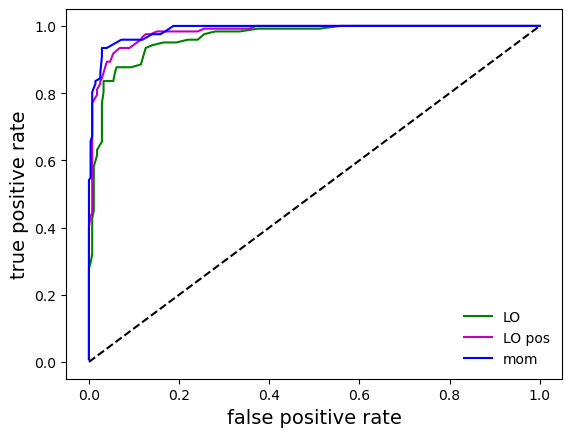

In [13]:
# function to calculate the ROC curve
def ROC(est_M, ref_M):
    # calculate true positive and false positive rates
    n = 100
    TPFP = np.zeros([n,2])
    # move threshold from min to max of est_M
    for i, th in enumerate(np.linspace(est_M.min(), est_M.max(), n)):
        TPFP[i,0] = np.logical_and(est_M>=th, ref_M).sum() / (ref_M).sum()
        TPFP[i,1] = np.logical_and(est_M>=th, np.logical_not(ref_M)).sum() / np.logical_not(ref_M).sum()
    return TPFP

plt.figure()
plt.plot([0,1], [0,1], '--k')
tpfp = ROC(C_LO, C_orig>0)
plt.plot(tpfp[:,1], tpfp[:,0], c='g', label='LO')
tpfp = ROC(C_LO_pos, C_orig>0)
plt.plot(tpfp[:,1], tpfp[:,0], c='m', label='LO pos')
tpfp = ROC(C_mom, C_orig>0)
plt.plot(tpfp[:,1], tpfp[:,0], c='b', label='mom')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

plt.show()

As a sanity check, we calculate the connectivity estimates from the theoretical covariances (i.e. knowing the original connectivity).

In [14]:
# compare with estimates from theoretical covariances
mou_LO_th = pm.MOU()
mou_LO_th.fit_from_cov(Q0_th, Q1_th, lag=1, method='lyapunov', eta_tau=0.05, max_iter=5000)
C_LO_th = np.copy(mou_LO_th.J)
C_LO_th[mask_diag] = 0.0

mou_mom_th = pm.MOU()
mou_mom_th.fit_from_cov(Q0_th, Q1_th, method='moments')
C_mom_th = np.copy(mou_mom_th.J)
C_mom_th[mask_diag] = 0.0

print('- model fit of covariances')
print('LO:',mou_LO_th.d_fit['correlation'])
print('moments:',mou_mom_th.d_fit['correlation'])
print()
print('- fit with original C')
print('LO',stt.pearsonr(C_orig.flatten(),C_LO_th.flatten()))
print('moments',stt.pearsonr(C_orig.flatten(),C_mom_th.flatten()))

- model fit of covariances
LO: 0.9999999999999999
moments: 0.6123907604490306

- fit with original C
LO PearsonRResult(statistic=np.float64(0.9999999999999999), pvalue=np.float64(0.0))
moments PearsonRResult(statistic=np.float64(0.9999999999999999), pvalue=np.float64(0.0))


## Estimated asymmetry

Finally, we compare the asymmetry of the estimates with that of the original connectivity.

In [15]:
# function to calculate the matrix asymmetry
def asym(M):
    return np.abs(M-M.T).sum() / np.abs(M).sum() / 2

print('asym C orig:', asym(C_orig))
print('asym C LO:', asym(C_LO))
print('asym C LO topo:', asym(C_LO_topo))
print('asym C LO pos:', asym(C_LO_pos))
print('asym C mom:', asym(C_mom))
print('asym C LO th:', asym(C_LO_th))
print('asym C mom th:', asym(C_mom_th))

asym C orig: 0.7581935797761813
asym C LO: 0.5115512533612558
asym C LO topo: 0.781083156094747
asym C LO pos: 0.6267490864004347
asym C mom: 0.7210821399417813
asym C LO th: 0.758193579776142
asym C mom th: 0.75819357977618
